In [4]:
# # \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# # \\                                                                                       \\ 
# # \\ THIS CELL SAVES THE GOODRUNS IN A SEPARATE FOLDER AFTER FIXING THE ORBIT NUMBER RESET \\
# # \\                                     RUN ONCE                                          \\
# # \\                                                                                       \\
# # \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


# #Original code for this cell at https://github.com/theofil/dscout/blob/master/analysis/exampleAnalysis.ipynb
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import os
# import subprocess
# import bz2
# %matplotlib inline

# plt.rc('font', size=15)



# # data files
# path = './data/hiion/' #  The files in this path have been manually processed (removed empty files, and merged a run with two parts into one)
# files = os.listdir(path)
# files = [f for f in files if 'monitor' not in f]

# # getrunNumber from string e.g., int('/data/hiion/scout_326676_000000.monitor.txt'.split('_')[1]
# getRun = lambda x: int(x.split('_')[1])



# # list to hold dataframes
# dfs = []
# runIndex= []

# for file in files:
#     filepath = path+file
#     df = pd.read_csv(filepath)
    
  
#     # add a column with the run number
#     df['run'] = getRun(file) 
#     dfs += [df]
    
#     #make in index with the run numbers
#     runIndex += [getRun(file)]
# plt.rc('figure', max_open_warning = 100)


# #Fix the runs where the orbit number resets (the warning does not matter)

# for df in dfs:
#     if not df['orbit'].is_monotonic:
#         for i in range(1,len(df)):
#             if df['orbit'][i-1]>df['orbit'][i]:
#                 tmp = i-1
#                 break
#         df['orbit'][tmp+1:] = df['orbit'][tmp] + df['orbit'][tmp+1:]

        
# badruns = [0, 1, 4, 8, 9, 11, 28, 30, 33, 34, 35, 36, 39, 46, 47, 50,  57, 65, 68, 69, 70, 72, 77, 78]
# goodruns = [i for i in range(len(dfs)) if i not in badruns]

# dfg = [] #data frame with only goodruns

# for i in range(len(dfs)):
#     if i in goodruns : dfg.append(dfs[i])
        
# for df in dfg:
#     name = str(df['run'][0])+".txt"
#     df.to_csv("./data/goodRuns/"+name, index = False) # The folder goodRuns needs to be manually made

C:\Users\George\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time 
import datetime
%matplotlib inline

class RUN:
    timePerOrbit = 110*24.95
            
    def __init__(self, dataFrame):
        
        self.events = len(df)
        self.df = dataFrame
        

        
        self.orbitMin  = self.df['orbit'][:1].values[0]
        self.orbitMax  = self.df['orbit'][-1:].values[0] 
        self.nOrbits= self.orbitMax - self.orbitMin
        self.rectime   = self.nOrbits * RUN.timePerOrbit # in ns
        self.rectimeSECONDS   = self.nOrbits * RUN.timePerOrbit * 10**(-9) # in s
        
        if (self.df['run'][0] == self.df['run'][len(df)-1]): # This code is not intended for use on merged runs
            self.run = self.df['run'][0]   
            TimeLog = pd.read_csv("https://raw.githubusercontent.com/theofil/dscout/master/analysis/runsDateTimeLog.txt",
                          delimiter = ', ', engine = 'python')

            for i in range(len(TimeLog['run'])):
                if TimeLog['run'][i] == self.run : 
                    index = i 
                    break

            duration = TimeLog['duration'][index]
            self.tStart = TimeLog['time_start'][index]
            self.tEnd = TimeLog['time_end'][index]
            h, m, s=duration.split(":")
            durationSecs = datetime.timedelta(hours = int(h), minutes = int(m), seconds = int(s)).total_seconds()
    #       --------------------------        
            self.duration = durationSecs
            self.naiveRate = self.events/durationSecs # in seconds
    #       --------------------------    
    
    def rate(self, timeUnit = 1, graph = False, printInfo = False):
        
        orbitMin = self.orbitMin 
        orbitMax = self.orbitMax
        df = self.df['orbit']
        timeUnit = timeUnit*1e9 # desired time in seconds
        orbitsPerTimeUnit = timeUnit/RUN.timePerOrbit
        bins=int(self.nOrbits/orbitsPerTimeUnit) 
#         Depending on the time unit, some runs might have   orbitsPerTimeUnit > self.nOrbits
        if bins == 0: bins = 1  
        timePerBin = self.rectime/bins
        muons=np.zeros(bins)
        sclice=np.array([orbitMin+ ((orbitMax-orbitMin)/bins)*i for i in range(bins+1)])

        # Count the events in the first orbit = orbitMin
        for orbit in df:
            if(orbit > orbitMin): break
            if(orbit == orbitMin): muons[0] += 1

        df = df[int(muons[0]):] # We already counted the first orbit
        i = 0
        for orbit in df:
            while not (orbit > sclice[i] and orbit <= sclice[i + 1]) and i < bins-1: # Note the <= in 'orbit <= slicePlusOne[i]'. 
                i = i + 1                                                              # It is needed to capture the last orbit.
            muons[i] += 1

        # Maximum Likelihood Estimation of Poisson parameter
        Nmuons = int(muons.sum()) 
        Ninterval = len(muons) # How many time intervals

        mu = muons.mean()
        med = np.median(muons)
        sigma = muons.std()
        MLE = Nmuons/Ninterval

        # 99% Confidence interval under gaussian approximation

        error = 2.58 * np.sqrt(MLE/Ninterval)
        lower = MLE-error
        upper = MLE+error

        if (graph):
            
            muons = pd.Series(muons)
            counts = muons.value_counts().sort_index()
            
            plt.figure(figsize=(8,8))
            plt.errorbar([i for i in range(len(counts))], counts, yerr = np.sqrt(counts), fmt = 'o')
            plt.xlabel('nMuons / %2.1f s'%(timePerBin*1.e-9), fontsize = 20) # latex can be entered in the label's string
            plt.ylabel('Frequency', fontsize = 20)
            
            plt.show()

        return mu  # muons.mean() is the rate (events per timeUnit)

        if (printInfo):
        
            print('timePerOrbit %2.1f ns '%RUN.timePerOrbit)
            print('orbitMin %d orbitMax %d'%(self.orbitMin, self.orbitMax))
            print('nOrbits %d '%self.nOrbits)
            print('total recording time %2.4f ns (~= %2.1f s)' %(self.rectime, self.rectime*1.e-9))
            print('orbitsPerTimeUnit = %2.3f'%orbitsPerTimeUnit)
            print("bins = %d" %bins)
            print('--------------------------------')
            print('mean = {:.2f}' .format(mu))
            print('median = {:d}'.format(int(med)))             
            print('sample std = {:.2f}'.format( sigma))
            print('Gaussian 99% Confidence Interval = [{:.2f} , {:.2f} ]'.format(lower, upper))
            
    def pair(df, x):
        
        dfns = df.shift(-x)
        dfps = df.shift(+x)

        logicOS1 = (df.bx == dfns.bx - x) & (df.orbit == dfns.orbit) & (df.charge*dfns.charge < 0)
        OS1 = df[logicOS1].copy()

        logicOS2 = (df.bx == dfps.bx + x) & (df.orbit == dfps.orbit) & (df.charge*dfps.charge < 0)
        OS2 = df[logicOS2].copy()

        OS1 = OS1.reset_index()
        OS2 = OS2.reset_index()

        OS = OS1.merge(OS2, left_on=OS1.index, right_on=OS2.index, suffixes=('_in', '_out'))

        logicSS1 = (df.bx == dfns.bx - x) & (df.orbit == dfns.orbit) & (df.charge*dfns.charge > 0)
        SS1 = df[logicSS1].copy()

        logicSS2 = (df.bx == dfps.bx + x) & (df.orbit == dfps.orbit) & (df.charge*dfps.charge > 0)
        SS2 = df[logicSS2].copy()

        SS1 = SS1.reset_index()
        SS2 = SS2.reset_index()

        SS = SS1.merge(SS2, left_on=SS1.index, right_on=SS2.index, suffixes=('_in', '_out'))

        # slim the dataframes
        def slimDataFrame(df):
            df = df.drop(['run_in', 'index_in','index_out','key_0','orbit_out'], axis=1)
            df = df.rename(columns = {'run_out':'run','orbit_in':'orbit'})
            if False: df = df.set_index(['run','orbit','bx_in'])
            return df

        OS = slimDataFrame(OS)
        SS = slimDataFrame(SS)
        return (OS, SS)

    
        
        
        
        
        

In [232]:
# data files
path = './data/goodRuns/' #  The files in this path have been manually processed (removed empty files, and merged a run with two parts into one)
files = os.listdir(path)
files = [f for f in files]

# list to hold dataframes
dfg = []
absRate = []
naive = []
duration = []
rectime = []

for file in files:
    filepath = path+file
    df = pd.read_csv(filepath)
    dfg.append(df)
    
    runObj = RUN(df)
    
    absRate.append(runObj.events/runObj.rectimeSECONDS)
    duration.append(runObj.duration)
    rectime.append(runObj.rectimeSECONDS)


In [233]:
duration = np.array(duration)
rectime = np.array(rectime)
timeRatio = (duration/rectime)




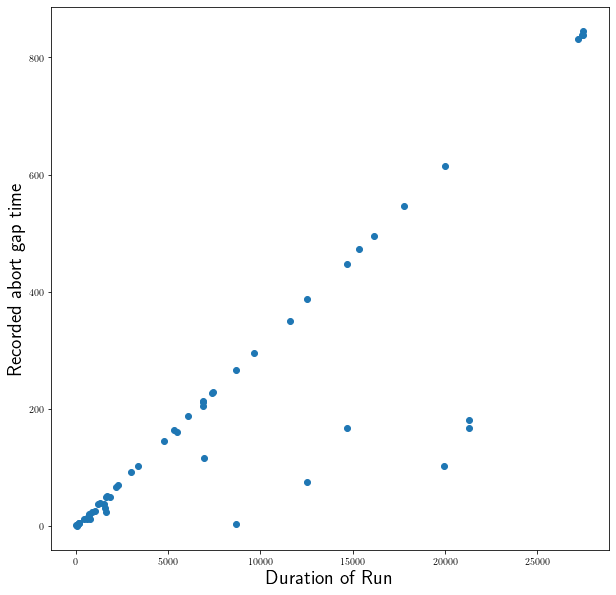

In [234]:
plt.figure(figsize = (10,10))
plt.scatter(duration,rectime)
plt.xlabel('Duration of Run', fontsize = 20)
plt.ylabel('Recorded abort gap time', fontsize = 20)
plt.show()

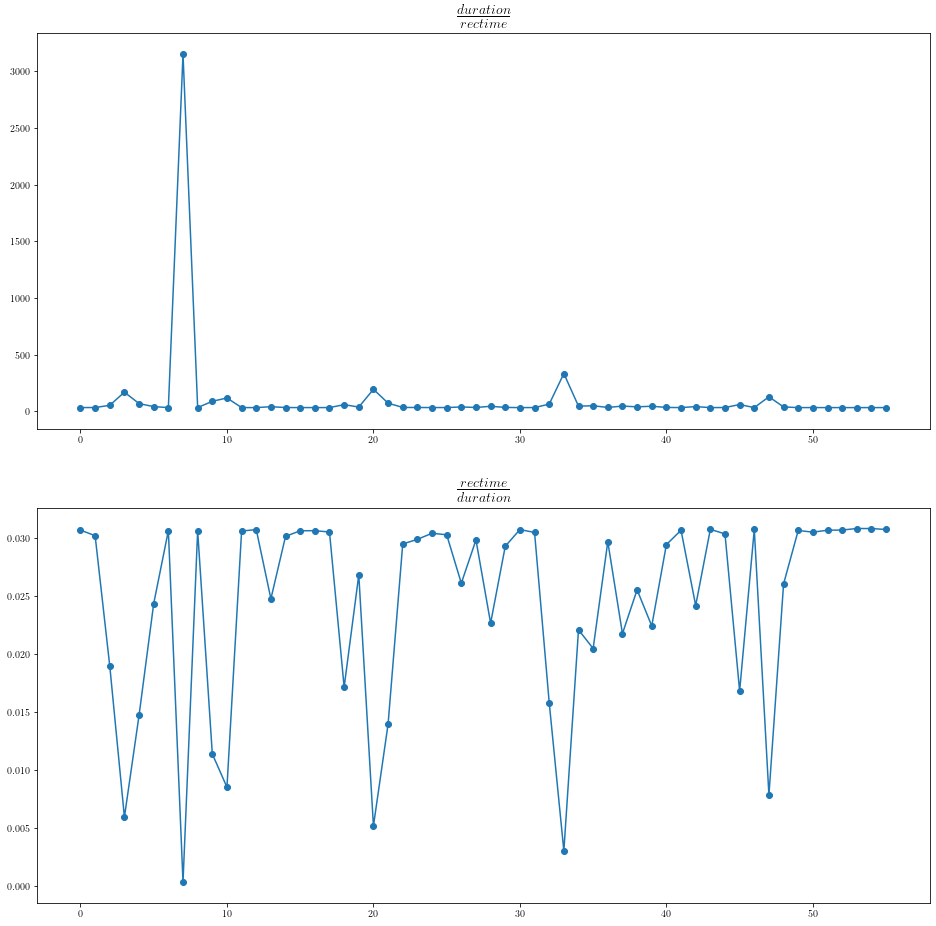

In [235]:
fig = plt.figure(figsize = (16,16))
plt.rc('text', usetex=True)
ax1 = fig.add_subplot(2,1,1)


ax1.plot([i for i in  range(len(timeRatio))], timeRatio)
ax1.scatter([i for i in  range(len(timeRatio))], timeRatio)
#ax1.set_xlabel('Run Index')
ax1.set_title(r'$\frac{duration}{rectime}$', fontsize = 20)

ax2 = fig.add_subplot(2,1,2, sharex = ax1)


ax2.plot([i for i in  range(len(timeRatio))], 1/timeRatio)
ax2.scatter([i for i in  range(len(timeRatio))], 1/timeRatio)
#ax2.set_xlabel('Run Index',  fontsize = 20)
ax2.set_title(r'$\frac{rectime}{duration}$', fontsize = 20)




plt.show()

In [236]:
absRate = np.array(absRate)
absRateErr = np.sqrt(absRate)



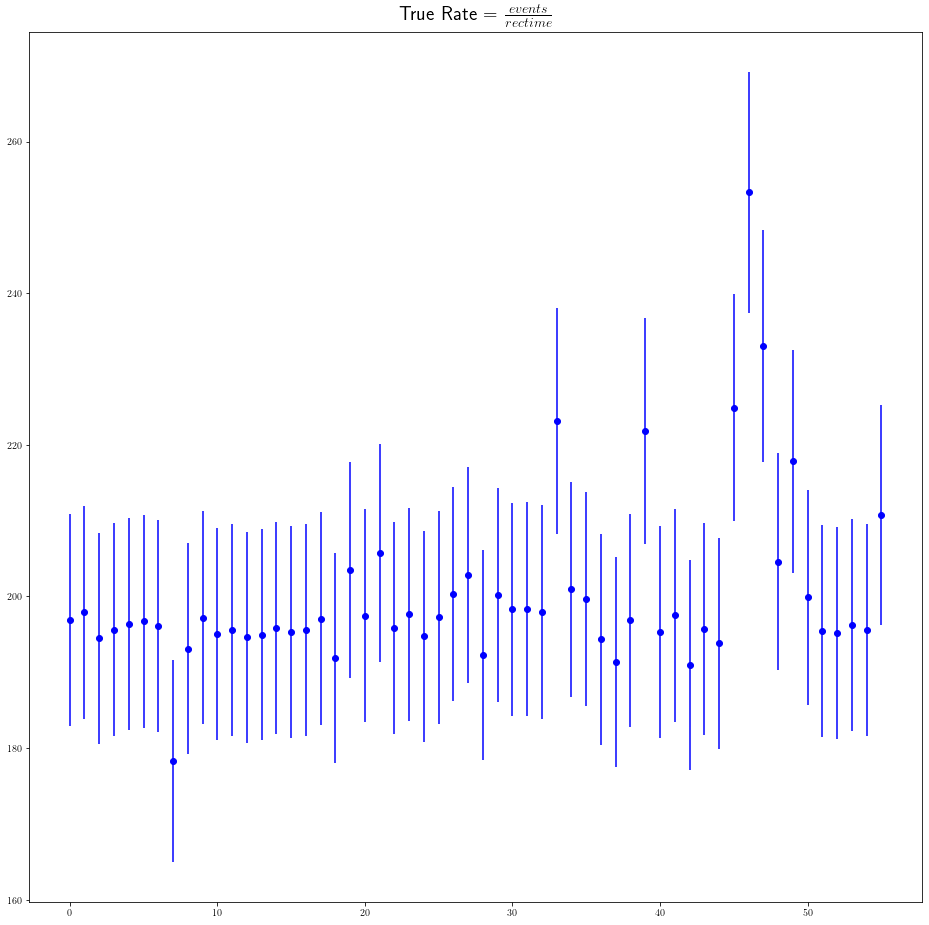

In [237]:
fig = plt.figure(figsize = (16,16))
plt.rc('text', usetex=True)
ax1 = fig.add_subplot(1,1,1)


#ax1.plot([i for i in  range(len(absRate))], absRate)
ax1.errorbar([i for i in  range(len(absRate))], absRate, yerr = absRateErr,  fmt='o', c = "blue")
#ax1.set_xlabel('Run Index')
ax1.set_title(r'True Rate = $\frac{events}{rectime}$', fontsize = 20)
plt.show()

In [238]:
TimeLog = pd.read_csv("https://raw.githubusercontent.com/theofil/dscout/master/analysis/runsDateTimeLog.txt",
                          delimiter = ', ', engine = 'python')
TimeLog.head()

,run,duration,date_start,time_start,date_end,time_end
0,326305,02:24:49,2018-11-07,21:04:17,2018-11-07,23:29:06
1,326309,01:19:26,2018-11-08,01:30:02,2018-11-08,02:49:28
2,326354,00:26:08,2018-11-08,13:55:44,2018-11-08,14:21:52
3,326398,03:29:07,2018-11-09,05:11:20,2018-11-09,08:40:27
4,326428,00:27:22,2018-11-09,11:25:48,2018-11-09,11:53:10


In [239]:
log_run = TimeLog['run'].to_list()
log_duration = TimeLog['duration'].to_list()
log_date_start = TimeLog['date_start'].to_list()
log_time_start = TimeLog['time_start'].to_list()
log_date_end = TimeLog['date_end'].to_list()
log_time_end = TimeLog['time_end'].to_list()
log_datetime_start = []
log_datetime_end = []
for i in range(len(TimeLog)):
    log_datetime_start.append(log_date_start[i]+' '+log_time_start[i]+'.0')
    log_datetime_end.append(log_date_end[i]+' '+log_time_end[i]+'.0')
    log_duration[i] = log_duration[i]+'.0'

In [240]:
datetime_start =pd.Series(log_datetime_start).apply(pd.to_datetime)
datetime_end =  pd.Series(log_datetime_end).apply(pd.to_datetime)
log_duration = pd.Series(log_duration).apply(pd.to_timedelta)

In [241]:
d = {'run': log_run, 'duration': log_duration, 'datetime_start': datetime_start, 'datetime_end': datetime_end}
TimeLog = pd.DataFrame(data = d)
# We need the midpoint to specify where the data dot will be
TimeLog['midpoint'] = TimeLog['datetime_start']+(TimeLog['datetime_end']-TimeLog['datetime_start'])/2
TimeLog.head()

,run,duration,datetime_start,datetime_end,midpoint
0,326305,02:24:49,2018-11-07 21:04:17,2018-11-07 23:29:06,2018-11-07 22:16:41.500
1,326309,01:19:26,2018-11-08 01:30:02,2018-11-08 02:49:28,2018-11-08 02:09:45.000
2,326354,00:26:08,2018-11-08 13:55:44,2018-11-08 14:21:52,2018-11-08 14:08:48.000
3,326398,03:29:07,2018-11-09 05:11:20,2018-11-09 08:40:27,2018-11-09 06:55:53.500
4,326428,00:27:22,2018-11-09 11:25:48,2018-11-09 11:53:10,2018-11-09 11:39:29.000


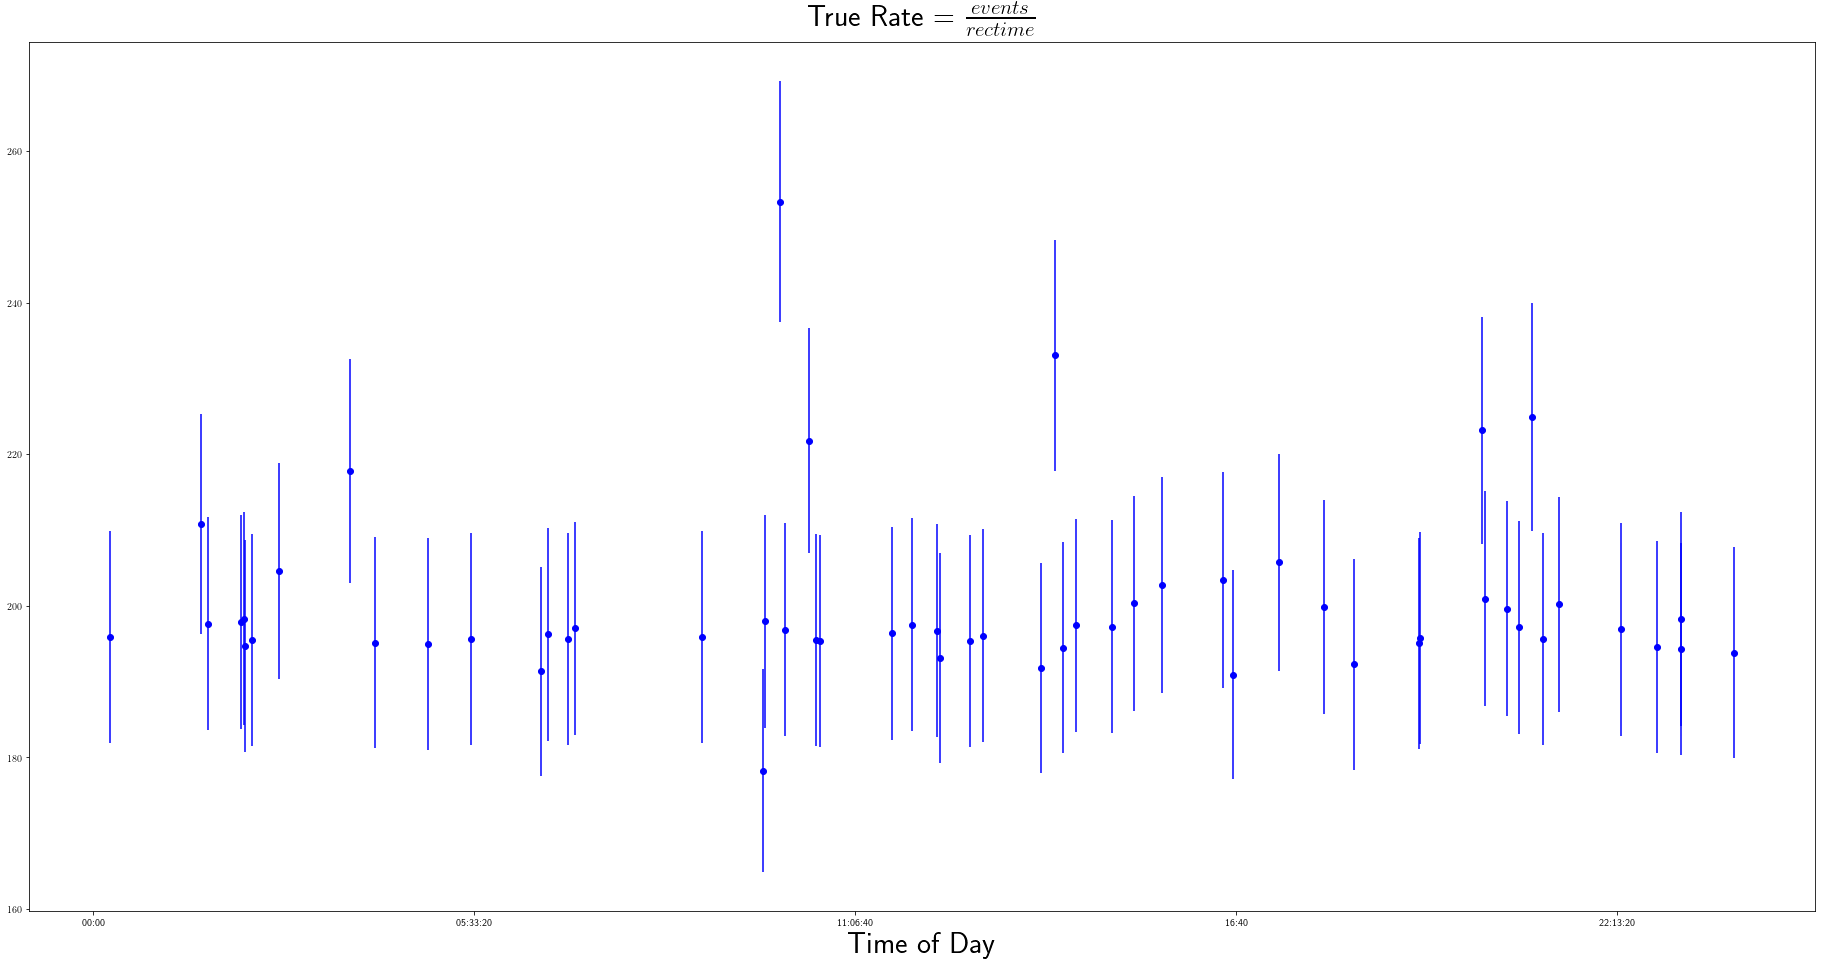

In [242]:
fig = plt.figure(figsize = (32,16))
plt.rc('text', usetex=True)
ax1 = fig.add_subplot(1,1,1)

timeMidpoint = [TimeLog['midpoint'][i].time() for i in range(len(TimeLog))]
timeMidpointErr = TimeLog['duration']/2+ datetime.timedelta(microseconds = 1)

ax1.errorbar(timeMidpoint, absRate, yerr = absRateErr, xerr = None , fmt='o', c = "blue")
ax1.set_xlabel('Time of Day', fontsize = 30)
ax1.set_title(r'True Rate = $\frac{events}{rectime}$', fontsize = 30)
plt.show()

In [243]:
x= TimeLog['duration']
x[1].microseconds

0

In [244]:
x

0    02:24:49
1    01:19:26
2    00:26:08
3    03:29:07
4    00:27:22
5    00:07:53
6    00:36:22
7    02:24:42
8    02:40:35
9    04:05:03
10   05:55:03
11   07:36:39
12   07:38:15
13   00:17:10
14   03:13:12
15   04:29:05
16   07:32:54
17   07:37:40
18   00:10:35
19   00:14:41
20   05:32:05
21   00:01:00
22   01:55:14
23   00:20:38
24   00:38:10
25   00:27:05
26   00:03:22
27   00:27:58
28   00:10:45
29   01:31:11
30   01:55:20
31   04:04:33
32   00:12:43
33   00:01:37
34   00:02:06
35   00:12:08
36   00:22:10
37   00:03:19
38   00:31:28
39   00:00:34
40   00:11:45
41   01:41:26
42   00:25:43
43   04:55:53
44   00:50:02
45   01:55:27
46   02:04:06
47   05:55:20
48   00:03:10
49   01:55:00
50   00:55:59
51   02:03:09
52   01:29:03
53   03:29:04
54   04:15:19
55   05:32:53
Name: duration, dtype: timedelta64[ns]

In [245]:
# Now we add the xerr
fig = plt.figure(figsize = (32,16))
plt.rc('text', usetex=True)
ax1 = fig.add_subplot(1,1,1)

timeMidpoint = [TimeLog['midpoint'][i].time() for i in range(len(TimeLog))]
timeMidpointErr = TimeLog['duration']/2+ datetime.timedelta(microseconds = 1)

ax1.errorbar(timeMidpoint, absRate, yerr = absRateErr, xerr =  timeMidpointErr, fmt='o', c = "blue")
ax1.set_xlabel('Time of Day', fontsize = 30)
ax1.set_title(r'True Rate = $\frac{events}{rectime}$', fontsize = 30)
plt.show()

TypeError: unsupported operand type(s) for -: 'datetime.time' and 'Timedelta'

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000015BC4AB5AE8> (for post_execute):


ValueError: microsecond must be in 0..999999

ValueError: microsecond must be in 0..999999

<Figure size 2304x1152 with 1 Axes>